In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time

In [108]:
timeseries = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/timeseries_Browsers_AltSS_μM12_hrM_η0_030825')
equilibria = pd.read_pickle('/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/equilibria_Browsers_AltSS_μM12_hrM_η0_030825')

In [109]:
equilibria

,rC,rM,rT,αCT,αMT,αMC,μC,μM,μT,hB,...,eS,pS,C_prime,M_prime,T_prime,F_prime,B_prime,G_prime,S_prime,color_col
0,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0,7.500000e-01,2.650397e-263,1.021429e-06,0.249999,3.750000e-01,0.0,0.0,allC
1,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0,7.500000e-01,2.650397e-263,1.629723e-07,0.250000,3.750000e-01,0.0,0.0,allC
2,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0,7.500000e-01,2.650397e-263,1.673797e-06,0.249998,3.750000e-01,0.0,0.0,allC
3,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0,7.500000e-01,2.650397e-263,5.246321e-07,0.249999,3.750000e-01,0.0,0.0,allC
4,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0,7.500000e-01,6.824771e-262,7.311600e-07,0.249999,3.750000e-01,0.0,0.0,allC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0,2.450720e-248,8.800000e-01,4.444107e-07,0.120000,4.019180e-248,0.0,0.0,allM
2416,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0,2.737962e-244,8.800000e-01,7.818722e-07,0.119999,4.490258e-244,0.0,0.0,allM
2417,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0,2.378931e-244,8.800000e-01,7.563203e-07,0.119999,3.901447e-244,0.0,0.0,allM
2418,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0,2.003226e-247,8.800000e-01,2.009776e-07,0.120000,3.285291e-247,0.0,0.0,allM


In [32]:
def plotPhPl(df, hB):
    
    df_PhPl = df[df['hB'] == hB]
    df_PhPl = df_PhPl.reset_index(drop=True)
    hB = round(hB, 3)
    x = len(df_PhPl)
    
    for i in range(x):

        C_array = df_PhPl['C_array'][i]
        M_array = df_PhPl['M_array'][i]
        T_array = df_PhPl['T_array'][i]

        if (C_array[-1] > M_array[-1]): #mostly-C (McManus et al., 2019)
            color = 'purple'
            linestyle = 'dotted'
            linewidth = 2
            alpha = 0.5

        if (M_array[-1] > C_array[-1]): #mostly-M (McManus et al., 2019)
            color = 'green'
            linestyle = 'dotted'
            linewidth = 2
            alpha = 0.5

        if (C_array[-1] > 0.01 and M_array[-1] < 0.01): #all-C (McManus et al., 2019)
            color = 'indigo'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        if (M_array[-1] > 0.01 and C_array[-1] < 0.01): #all-M (McManus et al., 2019)
            color = 'darkgreen'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        if (M_array[-1] < 0.01 and C_array[-1] < 0.01): #all-T (McManus et al., 2019)
            color = 'orange'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1
                    
        if (M_array[-1] < 0.01 and C_array[-1] < 0.01 and T_array[-1] < 0.01): #all-F (McManus et al., 2019)
            color = 'grey'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        plt.plot(C_array, M_array, color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha) # plot the trajectory in the phase plane (plot A)
        item1 = plt.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = plt.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red


    plt.legend([item1, item2], ['time step=0', 'time step=5,000'], fontsize=10)
    plt.xlabel("Coral Cover", fontsize=10);
    plt.ylabel("Macroalgae Cover", fontsize=10);
    plt.title('Coral-Algal Phase Plane (hB = ' +str(hB)+')', fontsize=14);

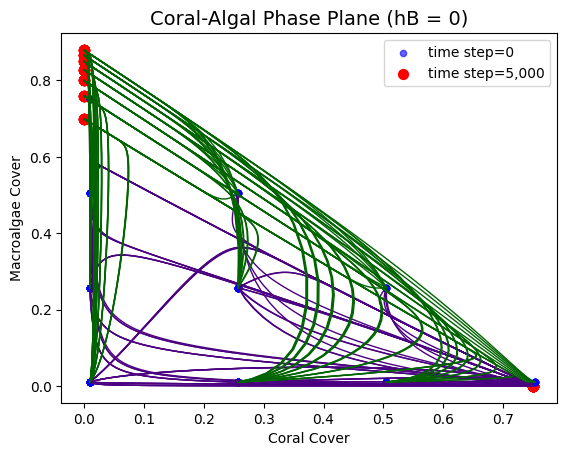

In [33]:
plotPhPl(timeseries, 0)
#plt.savefig("/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/Grazer_MacroDom_hB=4")

In [110]:
equilibria_C = equilibria[['rM', 'hB', 'C_prime', 'M_prime', 'T_prime', 'F_prime', 'B_prime']]

equilibria_C['C_prime'] = equilibria_C['C_prime'].round(2)
equilibria_C = equilibria_C.drop_duplicates(subset = ['hB', 'rM', 'C_prime'])
equilibria_C

C:\Users\gails\AppData\Local\Temp\ipykernel_37260\3002792877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  equilibria_C['C_prime'] = equilibria_C['C_prime'].round(2)


,rM,hB,C_prime,M_prime,T_prime,F_prime,B_prime
0,0.0,0.0,0.75,2.650397e-263,1.021429e-06,0.249999,3.750000e-01
20,0.1,0.0,0.75,6.908279e-192,1.183641e-06,0.249999,3.750000e-01
40,0.2,0.0,0.75,1.797737e-120,2.991449e-07,0.250000,3.750000e-01
60,0.3,0.0,0.75,7.250423e-49,2.860312e-07,0.250000,3.750000e-01
80,0.4,0.0,0.00,7.000000e-01,1.672170e-07,0.300000,7.819587e-41
...,...,...,...,...,...,...,...
2370,0.8,1.0,0.75,5.434722e-323,3.473658e-07,0.250000,3.750000e-01
2380,0.9,1.0,0.00,8.666667e-01,4.747971e-07,0.133333,7.022027e-222
2396,0.9,1.0,0.75,6.422853e-323,3.733697e-07,0.250000,3.750000e-01
2400,1.0,1.0,0.00,8.800000e-01,1.777555e-06,0.119998,2.100772e-249


In [111]:
#finding bistability

plot_df = []

h_val = np.linspace(0,1,11)
rM_val = np.linspace(0,1,11)
    
for rM in rM_val:

    for hB in h_val:

        subset = equilibria_C[equilibria_C['rM'] == rM]
        subset = subset[subset['hB'] == hB] #for each value of rM, select value of hB
        
        if subset.shape[0] >= 2: #if when rM = value and hB = value, there are two or more unique rows, AltSS are present
            #subset = subset[subset['hB'] == max(subset['hB'])]
            plot_df.append(subset)

plot_df

C_plot = pd.concat(plot_df, ignore_index=True)

C_plot

,rM,hB,C_prime,M_prime,T_prime,F_prime,B_prime
0,0.4,0.1,0.00,7.000000e-01,1.889490e-06,0.299998,9.812305e-41
1,0.4,0.1,0.75,5.754581e-61,4.347335e-07,0.250000,3.750000e-01
2,0.4,0.2,0.00,7.000000e-01,1.204750e-06,0.299999,1.288200e-40
3,0.4,0.2,0.75,5.902277e-142,3.515201e-07,0.250000,3.750000e-01
4,0.4,0.3,0.00,7.000000e-01,3.602628e-07,0.300000,1.809782e-40
...,...,...,...,...,...,...,...
87,0.9,1.0,0.75,6.422853e-323,3.733697e-07,0.250000,3.750000e-01
88,1.0,0.9,0.00,8.800000e-01,2.404944e-06,0.119998,2.068950e-249
89,1.0,0.9,0.75,1.523636e-285,2.290039e-07,0.250000,3.750000e-01
90,1.0,1.0,0.00,8.800000e-01,1.777555e-06,0.119998,2.100772e-249


In [270]:

bistable = []
array = list(range(len(C_plot)))

for i in array:

    rM_val = list(C_plot['rM'])[i]
    hB_val = list(C_plot['hB'])[i]

    equilibria_bi = equilibria[(equilibria['rM'] == rM_val) & (equilibria['hB'] == hB_val)]

    bistable.append(equilibria_bi)

bistable = pd.concat(bistable, ignore_index=False)

bistable['Bistable'] = [1]*len(bistable)


In [271]:
equilibria['Bistable'] = [0]*len(equilibria)

equilibria.loc[bistable.index] = bistable

equilibria_bi = equilibria

equilibria_bi

,rC,rM,rT,αCT,αMT,αMC,μC,μM,μT,hB,...,pS,C_prime,M_prime,T_prime,F_prime,B_prime,G_prime,S_prime,color_col,Bistable
0,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,2.650397e-263,1.021429e-06,0.249999,3.750000e-01,0.0,0.0,allC,0
1,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,2.650397e-263,1.629723e-07,0.250000,3.750000e-01,0.0,0.0,allC,0
2,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,2.650397e-263,1.673797e-06,0.249998,3.750000e-01,0.0,0.0,allC,0
3,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,2.650397e-263,5.246321e-07,0.249999,3.750000e-01,0.0,0.0,allC,0
4,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,6.824771e-262,7.311600e-07,0.249999,3.750000e-01,0.0,0.0,allC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.800000e-01,4.444107e-07,0.120000,4.019180e-248,0.0,0.0,allM,1
2416,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.800000e-01,7.818722e-07,0.119999,4.490258e-244,0.0,0.0,allM,1
2417,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.800000e-01,7.563203e-07,0.119999,3.901447e-244,0.0,0.0,allM,1
2418,0.2,1.0,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.800000e-01,2.009776e-07,0.120000,3.285291e-247,0.0,0.0,allM,1


In [272]:
equilibria_bi['C_prime'] = equilibria_bi['C_prime'].round(2)
equilibria_bi = equilibria_bi.drop_duplicates(subset = ['hB', 'rM']) #note you removed C_prime here
equilibria_bi


,rC,rM,rT,αCT,αMT,αMC,μC,μM,μT,hB,...,pS,C_prime,M_prime,T_prime,F_prime,B_prime,G_prime,S_prime,color_col,Bistable
0,0.2,0.0,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,2.650397e-263,1.021429e-06,0.249999,3.750000e-01,0.0,0.0,allC,0
20,0.2,0.1,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,6.908279e-192,1.183641e-06,0.249999,3.750000e-01,0.0,0.0,allC,0
40,0.2,0.2,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,1.797737e-120,2.991449e-07,0.250000,3.750000e-01,0.0,0.0,allC,0
60,0.2,0.3,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.75,7.250423e-49,2.860312e-07,0.250000,3.750000e-01,0.0,0.0,allC,0
80,0.2,0.4,5,0.25,0.9,0.1,0.05,0.12,10,0.0,...,0,0.00,7.000000e-01,1.672170e-07,0.300000,7.819587e-41,0.0,0.0,allM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,0.2,0.6,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.000000e-01,3.404349e-07,0.200000,1.285298e-127,0.0,0.0,allM,1
2340,0.2,0.7,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.285714e-01,1.059597e-06,0.171428,7.915211e-162,0.0,0.0,allM,1
2360,0.2,0.8,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.500000e-01,2.040560e-07,0.150000,6.746500e-193,0.0,0.0,allM,1
2380,0.2,0.9,5,0.25,0.9,0.1,0.05,0.12,10,1.0,...,0,0.00,8.666667e-01,4.747971e-07,0.133333,7.022027e-222,0.0,0.0,allM,1


In [277]:
#equilibria_bi['color_col'].unique() 
#if anything more than two options, you will have to change this^^^^^^!!!!!!!!!!!!


#equilibria_bi['color_col'].replace('allM', 0, inplace = True)
#equilibria_bi['color_col'].replace('allC', 1, inplace = True)


equilibria_bi['hB'] = equilibria_bi['hB'].round(2)
equilibria_bi['rM'] = equilibria_bi['rM'].round(2)

#equilibria_bi['heatmap_values'] = equilibria_bi['color_col'] + equilibria_bi['Bistable']

In [273]:
equilibria_bi = equilibria_bi.reset_index()

equilibria_bi['heatmap_values'] = [1]*len(equilibria_bi)

array = list(range(len(equilibria_bi)))

for i in array:

    if (equilibria_bi['color_col'][i] == 'allM') & (list(equilibria_bi['Bistable'])[i] == 1):
        equilibria_bi['heatmap_values'][i] = 10
    
    elif (equilibria_bi['color_col'][i] == 'allC') & (list(equilibria_bi['Bistable'])[i] == 1):
        equilibria_bi['heatmap_values'][i] = 10
    
    elif (equilibria_bi['color_col'][i] == 'allM') & (list(equilibria_bi['Bistable'])[i] == 0):
        equilibria_bi['heatmap_values'][i] = 0
    
    elif (equilibria_bi['color_col'][i] == 'allC') & (list(equilibria_bi['Bistable'])[i] == 0):
        equilibria_bi['heatmap_values'][i] = 5


C:\Users\gails\AppData\Local\Temp\ipykernel_37260\595701670.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  equilibria_bi['heatmap_values'][i] = 5
C:\Users\gails\AppData\Local\Temp\ipykernel_37260\595701670.py:19: SettingWithCopyWarning

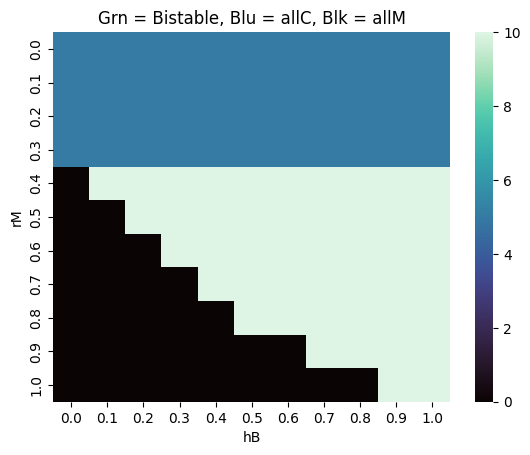

In [282]:
ax = plt.axes()

heatmap_df = (
    equilibria_bi
    .pivot(index="rM", columns="hB", values="heatmap_values")
)

sns.heatmap(heatmap_df, annot=False, ax=ax, cmap='mako')

ax.set_title('Grn = Bistable, Blu = allC, Blk = allM');

plt.savefig("/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/Browser_AltSS_μM12_hrM_η0_030825")

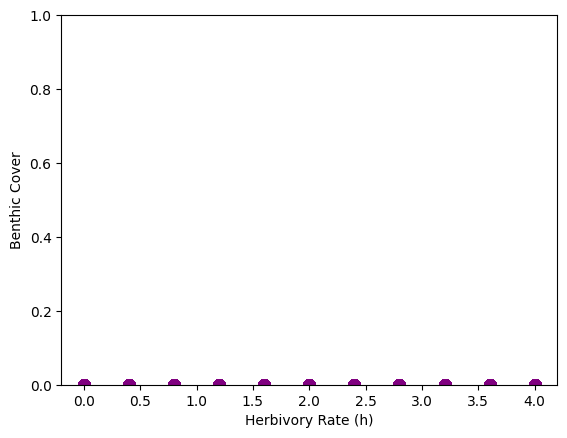

In [331]:
plt.scatter(equilibria['hG'], equilibria['C_prime'], c = 'purple', linewidth=3);
plt.ylim(0,1);
plt.ylabel('Benthic Cover');
plt.xlabel('Herbivory Rate (h)');

plt.savefig("/Users/gails/Desktop/Team Sediment/Chapter 1 - Theory/Current Analyses/Bifurcation_Grazer_MacroDom")

In [289]:
timeseries = timeseries
equilibria_C = equilibria
equilibria_M = equilibria

#Coral Upper
equilibria_C['C_prime'] = equilibria_C['C_prime'].round(2)
equilibria_C = equilibria_C.drop_duplicates(subset = ['hB', 'C_prime'])

plot_df = []
hB_array = np.linspace(0,4,11)

for hB in hB_array:
    subset = equilibria_C[equilibria_C['hB'] == hB]
    
    if subset['C_prime'].shape[0] == 2:
        subset = subset[subset['C_prime'] == max(subset['C_prime'])]

    plot_df.append(subset)

C_plot = pd.concat(plot_df, ignore_index=True)

#Macro Line
equilibria_M['M_prime'] = equilibria_M['M_prime'].round(2)
equilibria_M = equilibria_M.drop_duplicates(subset = ['hB', 'M_prime'])

plot_df = []
hB_array = np.linspace(0,4,11)

for hB in hB_array:
    subset = equilibria_M[equilibria_M['hB'] == hB]
    
    if subset['M_prime'].shape[0] == 2:
        subset = subset[subset['M_prime'] == max(subset['M_prime'])]

    plot_df.append(subset)

M_plot = pd.concat(plot_df, ignore_index=True)

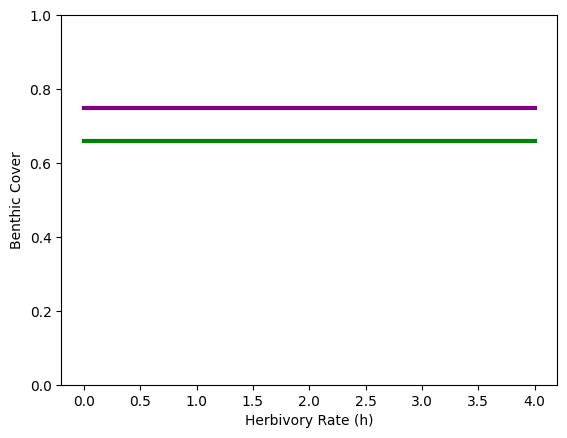

In [291]:
plt.plot(M_plot['hB'], C_plot['C_prime'], c = 'purple', linewidth=3);
plt.plot(M_plot['hB'], M_plot['M_prime'], c = 'green', linewidth=3);
#plt.scatter(equilibria['hB'], equilibria['T_prime'], c = 'orange', linestyle = 'dotted', linewidth=3);
plt.ylim(0,1);
plt.ylabel('Benthic Cover');
plt.xlabel('Herbivory Rate (h)');